# YOLOv8 vs SAM Meta

## Library

In [1]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

import numpy as np
import cv2
import os
import sys
import torch
from roboflow import Roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=8c2a196bb45fdf81f536398522ecad1df4e5d090d1c4ac3179718ffa395b3282
  Stored in directory: /root/.cache/p

In [2]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cqqotbrj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cqqotbrj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 3518c86b78b3bc9cf4fbe3d18e682fad1c79dc51
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36602 sha256=e2d767bb5e688ed60c0f10cbc0d2c42d42471f90f48d8308777a6db4e09e4159
  Stored in directory: /tmp/pip-ephem-wheel-cache-h4e9lbng/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

## Dataset (Roboflow)

In [5]:
rf = Roboflow(api_key="Pho4XVVaJnNcR3y3HNrK")
project = rf.workspace("team12").project("airplane-bp8fl")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.77, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to airplane-2 in yolov8:: 100%|██████████| 297/297 [00:00<00:00, 2326.90it/s]


In [6]:
IMAGE_NAME = '/content/airplane2.jpg'
IMG_SOURCE = cv2.imread(IMAGE_NAME)

In [7]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [11]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## YoloV8 - Creating BBox

In [29]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')
img = cv2.cvtColor(IMG_SOURCE, cv2.COLOR_BGR2RGB)
results = yolo_model.predict(source=img)


0: 448x640 2 airplanes, 78.8ms
Speed: 0.5ms preprocess, 78.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


In [30]:
res

for result in results:

    result_np = np.array(result.boxes.data.cpu())
    result_dict = {'x': result_np[0][0], 'y': result_np[0][1], 'width': result_np[0][2], 'height': result_np[0][3], 'label': result_np[0][5]}

In [31]:
result_dict

{'x': 92.43286,
 'y': 225.27199,
 'width': 678.7377,
 'height': 342.6791,
 'label': 4.0}

In [32]:
box = result_dict
box = np.array([
    box['x'], 
    box['y'], 
    box['width'], 
    box['height']
])
box

array([     92.433,      225.27,      678.74,      342.68], dtype=float32)

## SAM - Segmentation

In [22]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

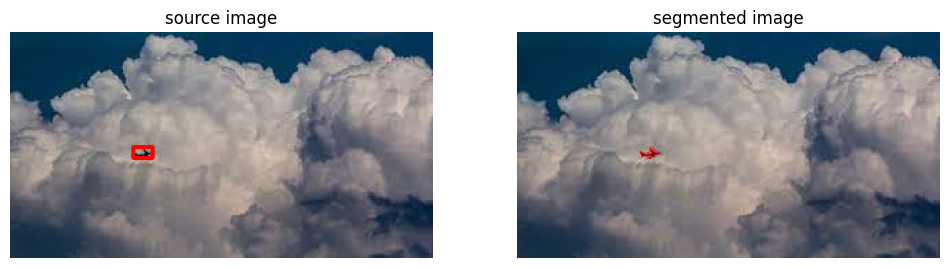

In [23]:
import supervision as sv

IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

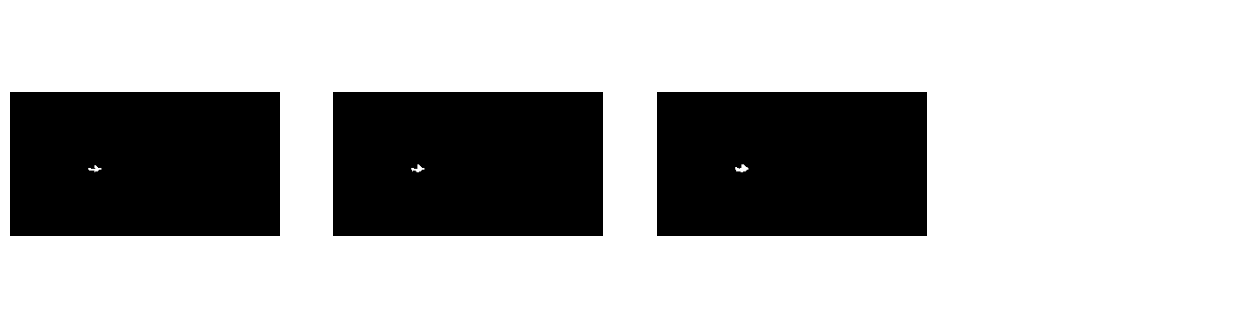

In [18]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)